In [1]:
NOTEBOOK_NAME = "e013_remove_train_last_yad_no"

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [3]:
class Config:
    OUTPUT_DIR = f"../saved_data/{NOTEBOOK_NAME}"
    SEED = 33
    TARGET_COL = "reserve"


os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [4]:
train_log = pd.read_csv("../data/train_log.csv")
train_label = pd.read_csv("../data/train_label.csv")

test_log = pd.read_csv("../data/test_log.csv")
test_session = pd.read_csv("../data/test_session.csv")

yado = pd.read_csv("../data/yado.csv")

sample_submission = pd.read_csv("../data/sample_submission.csv")

# # image_embeddings = pd.read_parquet("../data/image_embeddings.parquet")

In [5]:
train = pd.read_pickle(
    f"../saved_data/e013_make_train_retrieve_sale_lrg_cd_remove_last_yad_no/e013_make_train_retrieve_sale_lrg_cd_remove_last_yad_no_merged_train.pkl"
)

test = pd.read_pickle(
    f"../saved_data/e013_make_train_retrieve_sale_lrg_cd_remove_last_yad_no/e013_make_train_retrieve_sale_lrg_cd_remove_last_yad_no_merged_test.pkl"
)

In [6]:
# # debug
# train = train.sample(10000, random_state=Config.SEED).reset_index(drop=True)
# test = test.sample(10000, random_state=Config.SEED).reset_index(drop=True)

In [7]:
# debug用
# train = train.sample(10000, random_state=SEED)

In [8]:
# # ひとつ前のlogのyad_idの値を取得
# train["previous_1_yad_no"] = train["logged_yad_no_list"].apply(lambda x: x[-1])
# test["previous_1_yad_no"] = test["logged_yad_no_list"].apply(lambda x: x[-1])

# Sessionの情報を追加

In [9]:
def add_session_length(
    train: pd.DataFrame,
    train_log: pd.DataFrame,
    test: pd.DataFrame,
    test_log: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    sessionの長さを追加する
    """
    train_session_id_cnt_dict = (
        train_log.groupby("session_id")["yad_no"].count().to_dict()
    )
    test_session_id_cnt_dict = (
        test_log.groupby("session_id")["yad_no"].count().to_dict()
    )

    train["session_length"] = train["session_id"].map(train_session_id_cnt_dict)
    test["session_length"] = test["session_id"].map(test_session_id_cnt_dict)

    return train, test


train, test = add_session_length(train, train_log, test, test_log)

In [10]:
def add_session_yado_nunique(
    train: pd.DataFrame,
    train_log: pd.DataFrame,
    test: pd.DataFrame,
    test_log: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    sessionの中で登場したyadoの数を追加する
    """
    train_session_yado_cnt_dict = (
        train_log.groupby("session_id")["yad_no"].nunique().to_dict()
    )
    test_session_yado_cnt_dict = (
        test_log.groupby("session_id")["yad_no"].nunique().to_dict()
    )

    train["session_yado_nunique"] = train["session_id"].map(train_session_yado_cnt_dict)
    test["session_yado_nunique"] = test["session_id"].map(test_session_yado_cnt_dict)

    return train, test


train, test = add_session_yado_nunique(train, train_log, test, test_log)

In [11]:
def add_session_yado_cnt(
    train: pd.DataFrame,
    train_log: pd.DataFrame,
    test: pd.DataFrame,
    test_log: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    sessionとyadごとに、yad_noが登場した回数を数える
    """
    train_session_yado_cnt_dict = (
        train_log.groupby(["session_id", "yad_no"])["yad_no"].count().to_dict()
    )
    test_session_yado_cnt_dict = (
        test_log.groupby(["session_id", "yad_no"])["yad_no"].count().to_dict()
    )

    train["session_yado_cnt"] = train.apply(
        lambda x: train_session_yado_cnt_dict[(x["session_id"], x["yad_no"])]
        if (x["session_id"], x["yad_no"]) in train_session_yado_cnt_dict
        else 0,
        axis=1,
    )
    test["session_yado_cnt"] = test.apply(
        lambda x: test_session_yado_cnt_dict[(x["session_id"], x["yad_no"])]
        if (x["session_id"], x["yad_no"]) in test_session_yado_cnt_dict
        else 0,
        axis=1,
    )

    return train, test


train, test = add_session_yado_cnt(train, train_log, test, test_log)

# 正解のyadoと1つ前のyadoの情報の追加

In [12]:
# 正解のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# # 1つ前のyado情報の追加
# train = pd.merge(
#     train,
#     yado.add_prefix("previous_1_"),
#     on="previous_1_yad_no",
#     how="left",
# )

In [13]:
# 正解のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# # 1つ前のyado情報の追加
# test = pd.merge(
#     test,
#     yado.add_prefix("previous_1_"),
#     on="previous_1_yad_no",
#     how="left",
# )

# データ型の変更

In [14]:
# categorical_colの定義
base_categorical_cols = [
    "yad_no",
    "yad_type",
    # "wid_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    # "ken_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    # "lrg_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "sml_cd",
]
now_yado_categorical_cols = [f"now_{col}" for col in base_categorical_cols]
# previous_1_yado_categorical_cols = [
#     f"previous_1_{col}" for col in base_categorical_cols
# ]

# categorical_cols = now_yado_categorical_cols + previous_1_yado_categorical_cols
categorical_cols = now_yado_categorical_cols

In [15]:
# categorical_cols.remove("now_yad_no")
# categorical_cols.remove("previous_1_yad_no")

# # leak的な何かしらが起きているので、今は使わない
# # TODO: 予測するyad_noは重要な情報だと思うため入れ方を考える

In [16]:
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

# Fold

In [17]:
# Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
FOLD_NUM = 5

# skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
# for fold, (_, v_idx) in enumerate(
#     skf.split(train, pd.cut(train["reserve"], bins=3, labels=["0", "0.5", "1"]))
# ):
#     train.loc[v_idx, "fold"] = fold

# sgkf = StratifiedGroupKFold(n_splits=FOLD_NUM, shuffle=True, random_state=Config.SEED)
# for fold, (_, v_idx) in enumerate(
#     sgkf.split(
#         X=train,
#         y=train["reserve"],
#         groups=train["session_id"],
#     )
# ):
#     train.loc[v_idx, "fold"] = fold

gkf = GroupKFold(n_splits=FOLD_NUM)
for fold, (_, v_idx) in enumerate(
    gkf.split(
        X=train,
        groups=train["session_id"],
    )
):
    train.loc[v_idx, "fold"] = fold

train["fold"] = train["fold"].astype(int)

In [18]:
train.groupby("fold")["reserve"].value_counts(normalize=True)

fold  reserve
0     0          0.908805
      1          0.091195
1     0          0.908804
      1          0.091196
2     0          0.908804
      1          0.091196
3     0          0.908804
      1          0.091196
4     0          0.908805
      1          0.091195
Name: proportion, dtype: float64

# LightGBM

In [19]:
# numeric_colの定義
base_numeric_col = [
    "total_room_cnt",
    "wireless_lan_flg",
    "onsen_flg",
    "kd_stn_5min",
    "kd_bch_5min",
    "kd_slp_5min",
    "kd_conv_walk_5min",
]

now_yado_numeric_col = [f"now_{col}" for col in base_numeric_col]
previous_1_yado_numeric_col = [f"previous_1_{col}" for col in base_numeric_col]

# session系の特徴量
session_numeric_col = [
    "session_length",
    "session_yado_nunique",
    "session_yado_cnt",
]

# numeric_cols = now_yado_numeric_col + previous_1_yado_numeric_col
# numeric_cols = now_yado_numeric_col
numeric_cols = now_yado_numeric_col + session_numeric_col

In [20]:
use_col = numeric_cols + categorical_cols
len(use_col)

13

In [21]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "max_depth": 3,
    # "min_data_in_leaf": 100, # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.3,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42,  # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "importance_type": "gain",
}

In [28]:
# params = {
#     # 目的関数. これの意味で最小となるようなパラメータを探します.
#     "objective": "binary",
#     # 木の最大数
#     "n_estimators": 10000,
#     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
#     # がそれだけ木を作るため学習に時間がかかります
#     # 今回設定している 0.3 は比較的大きめの設定です
#     "learning_rate": 0.3,
#     # 特徴重要度計算のロジック(後述)
#     "importance_type": "gain",
#     "random_state": 510,
# }

In [ ]:
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [29]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold]
    valid_fold = train[train["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop(Config.TARGET_COL, axis=1)
    X_valid = valid_fold.drop(Config.TARGET_COL, axis=1)
    y_train = train_fold[[Config.TARGET_COL]]
    y_valid = valid_fold[[Config.TARGET_COL]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=3000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(100),
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    # score = rmse(y_valid, y_valid_pred)
    score = roc_auc_score(y_valid, y_valid_pred)

    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred
    break

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.214307	valid_1's binary_logloss: 0.215619
[200]	training's binary_logloss: 0.210913	valid_1's binary_logloss: 0.213171
[300]	training's binary_logloss: 0.209422	valid_1's binary_logloss: 0.212339
[400]	training's binary_logloss: 0.208684	valid_1's binary_logloss: 0.212058
[500]	training's binary_logloss: 0.208331	valid_1's binary_logloss: 0.211899
[600]	training's binary_logloss: 0.208112	valid_1's binary_logloss: 0.211794
[700]	training's binary_logloss: 0.20782	valid_1's binary_logloss: 0.211632
[800]	training's binary_logloss: 0.207677	valid_1's binary_logloss: 0.211543
[900]	training's binary_logloss: 0.207453	valid_1's binary_logloss: 0.21135
[1000]	training's binary_logloss: 0.207328	valid_1's binary_logloss: 0.211332
[1100]	training's binary_logloss: 0.207234	valid_1's binary_logloss: 0.21128
[1200]	training's binary_logloss: 0.207047	valid_1's binary_logloss: 0.211111
[

In [30]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "wb") as f:
    pickle.dump(models, f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "wb") as f:
    pickle.dump(oof, f)

In [22]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "rb") as f:
    models = pickle.load(f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "rb") as f:
    oof = pickle.load(f)

In [23]:
# oof_score = rmse(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score = roc_auc_score(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score

0.8560017091637564

In [33]:
# # TODO: fold0のみだとスコアが小さく出てしまう問題を解決する
# # map@10を計算
# def create_top_10_yad_predict(oof: pd.DataFrame, train: pd.DataFrame) -> pd.DataFrame:
#     _df = pd.concat(
#         [train[["session_id", "yad_no"]], pd.Series(oof, name="predict")],
#         axis=1,
#     )

#     # セッションごとに予測確率の高い順に yad_no の配列を作成
#     _agg = (
#         _df.sort_values("predict", ascending=False)
#         .groupby("session_id")["yad_no"]
#         .apply(list)
#     )

#     out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]
#     out_df = out_df.fillna("0").astype(int)

#     return out_df


# # trainをoofが0でないものだけに絞る
# train_for_calc_mapk = train.copy()
# train_for_calc_mapk["oof"] = oof
# train_for_calc_mapk = train_for_calc_mapk[train_for_calc_mapk["oof"] != 0]

# # oofも、計算用に0以外の箇所に絞る
# oof_for_calc_mapk = oof[oof != 0]

# oof_pred_yad_df = create_top_10_yad_predict(
#     oof=oof_for_calc_mapk, train=train_for_calc_mapk
# )

# oof_pred_yad_df

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
00011afe25c343301ee961b3b0ce2e4d,10798,5401,6548,8993,4590,5248,3046,12544,13589,6959
00026fd325b5d65d18e6de78ea2a3751,12746,13484,756,1613,7167,4191,6877,6585,8852,2800
0003948318658b2072bc29e99415743e,6945,6576,2293,12524,6116,7474,4568,1368,569,6126
00044db9da5da40b1e0056ba487cdc28,10797,800,144,6787,7376,6826,1383,2874,13755,712
0005c4e37bf5d835cc0d5eae439c1689,2243,11044,13748,11767,3647,13555,13791,4503,236,4528
...,...,...,...,...,...,...,...,...,...,...
fffbff03d939d87e859b4d558fb275d4,611,1689,2361,3746,6688,7140,8208,8323,9379,10059
fffc37cadd396eaa102e76d984b315de,237,828,1527,2786,3465,4159,4612,6650,6808,13644
fffd17b181e26913f6c2ee48e7570a05,3735,5201,5351,5946,6363,10449,11710,11994,12522,12592


In [24]:
# trainをoofが0でないものだけに絞る
train_for_calc_mapk = train.copy()
train_for_calc_mapk["oof"] = oof
train_for_calc_mapk = train_for_calc_mapk[train_for_calc_mapk["oof"] != 0]

# 推論順にsession_idとyad_noを並べる
oof_pred_yad = (
    train_for_calc_mapk.sort_values(["session_id", "oof"], ascending=False)
    .groupby("session_id")["yad_no"]
    .apply(list)
).to_dict()

# train_labelをoofの計算用に用意
train_label_for_calc_oof = train_label.copy()

# train_for_calc_mapkに付与
train_label_for_calc_oof["pred_yad_no_list"] = train_label_for_calc_oof[
    "session_id"
].map(oof_pred_yad)

# oofが計算されていないsession_idは削除
train_label_for_calc_oof = train_label_for_calc_oof[
    train_label_for_calc_oof["pred_yad_no_list"].notnull()
].reset_index(drop=True)

# 上位10件に限定
train_label_for_calc_oof["pred_yad_no_list_top10"] = train_label_for_calc_oof[
    "pred_yad_no_list"
].apply(lambda x: x[:10])

# listをpd.Seriesに変換
oof_pred_df = train_label_for_calc_oof.set_index("session_id")[
    "pred_yad_no_list_top10"
].apply(pd.Series)
oof_pred_df = oof_pred_df.rename(columns=lambda x: "predict_" + str(x))

# Nullの箇所はyad_no=0で保管し、全ての値をintに変換する
# TODO: 埋めるのは0で本当に良いのか考える
oof_pred_df = oof_pred_df.fillna(0).astype(int)

oof_pred_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
session_id,,,,,,,,,,
00011afe25c343301ee961b3b0ce2e4d,12544,4823,13589,6959,6548,8993,5248,5401,3046,4590
00026fd325b5d65d18e6de78ea2a3751,756,7167,6877,12746,8852,11425,6585,2800,1613,13484
0003948318658b2072bc29e99415743e,569,6576,12524,7474,6116,2622,1368,6126,2293,6945
00044db9da5da40b1e0056ba487cdc28,1383,6787,2874,800,10797,144,13755,6826,11287,712
0005c4e37bf5d835cc0d5eae439c1689,4528,13555,10948,4503,11767,13748,3647,11044,2243,236
...,...,...,...,...,...,...,...,...,...,...
fffbff03d939d87e859b4d558fb275d4,10059,10595,3746,8323,7140,1689,2361,9379,6688,8208
fffc37cadd396eaa102e76d984b315de,6808,828,3465,2786,4612,6650,237,4159,13644,1527
fffd17b181e26913f6c2ee48e7570a05,11994,12522,3735,5946,12592,10449,5201,11710,6363,5351


In [25]:
# TODO: testでは最後のlogを除いているのに、trainには含めているのはいいのか考える
train[train["session_id"] == "00026fd325b5d65d18e6de78ea2a3751"]

,session_id,yad_no,reserve,session_length,session_yado_nunique,session_yado_cnt,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,now_kd_stn_5min,now_kd_bch_5min,now_kd_slp_5min,now_kd_conv_walk_5min,now_wid_cd,now_ken_cd,now_lrg_cd,now_sml_cd,fold
120,00026fd325b5d65d18e6de78ea2a3751,756,1,2,2,1,756,0,NaN,NaN,1,NaN,NaN,NaN,NaN,321b69d5eec98fe6253e26b86058e6a9,39c3eb151762dd35cf50e8bde404ae74,ef4accaed5974fd09e429a1901457578,9fbbf71e784c6b49e4244cde0a944c22,0
121,00026fd325b5d65d18e6de78ea2a3751,1613,0,2,2,0,1613,0,49.0,1.0,0,1.0,NaN,NaN,1.0,321b69d5eec98fe6253e26b86058e6a9,39c3eb151762dd35cf50e8bde404ae74,ef4accaed5974fd09e429a1901457578,ecc4ed098f3eba89d0cd6234a27922dc,0
122,00026fd325b5d65d18e6de78ea2a3751,2800,0,2,2,0,2800,0,48.0,1.0,1,1.0,NaN,NaN,NaN,321b69d5eec98fe6253e26b86058e6a9,39c3eb151762dd35cf50e8bde404ae74,ef4accaed5974fd09e429a1901457578,ecc4ed098f3eba89d0cd6234a27922dc,0
123,00026fd325b5d65d18e6de78ea2a3751,4191,0,2,2,0,4191,0,14.0,1.0,0,NaN,NaN,NaN,NaN,321b69d5eec98fe6253e26b86058e6a9,39c3eb151762dd35cf50e8bde404ae74,ef4accaed5974fd09e429a1901457578,ecc4ed098f3eba89d0cd6234a27922dc,0
124,00026fd325b5d65d18e6de78ea2a3751,6585,0,2,2,0,6585,0,61.0,1.0,1,1.0,NaN,NaN,1.0,321b69d5eec98fe6253e26b86058e6a9,39c3eb151762dd35cf50e8bde404ae74,ef4accaed5974fd09e429a1901457578,ecc4ed098f3eba89d0cd6234a27922dc,0
125,00026fd325b5d65d18e6de78ea2a3751,6877,0,2,2,0,6877,0,73.0,NaN,1,1.0,NaN,NaN,1.0,321b69d5eec98fe6253e26b86058e6a9,39c3eb151762dd35cf50e8bde404ae74,ef4accaed5974fd09e429a1901457578,ecc4ed098f3eba89d0cd6234a27922dc,0
126,00026fd325b5d65d18e6de78ea2a3751,7167,0,2,2,0,7167,0,145.0,1.0,0,1.0,NaN,NaN,1.0,321b69d5eec98fe6253e26b86058e6a9,39c3eb151762dd35cf50e8bde404ae74,ef4accaed5974fd09e429a1901457578,789f952bcb0ff4153ab2a6b2a5a4e976,0
127,00026fd325b5d65d18e6de78ea2a3751,8852,0,2,2,0,8852,0,152.0,1.0,0,NaN,NaN,NaN,1.0,321b69d5eec98fe6253e26b86058e6a9,39c3eb151762dd35cf50e8bde404ae74,ef4accaed5974fd09e429a1901457578,789f952bcb0ff4153ab2a6b2a5a4e976,0
128,00026fd325b5d65d18e6de78ea2a3751,11425,0,2,2,0,11425,0,90.0,1.0,1,NaN,NaN,NaN,NaN,321b69d5eec98fe6253e26b86058e6a9,39c3eb151762dd35cf50e8bde404ae74,ef4accaed5974fd09e429a1901457578,789f952bcb0ff4153ab2a6b2a5a4e976,0
129,00026fd325b5d65d18e6de78ea2a3751,12746,0,2,2,0,12746,0,77.0,1.0,0,NaN,NaN,NaN,1.0,321b69d5eec98fe6253e26b86058e6a9,39c3eb151762dd35cf50e8bde404ae74,ef4accaed5974fd09e429a1901457578,789f952bcb0ff4153ab2a6b2a5a4e976,0


In [26]:
train_log[train_log["session_id"] == "00026fd325b5d65d18e6de78ea2a3751"]

,session_id,seq_no,yad_no
12,00026fd325b5d65d18e6de78ea2a3751,0,756
13,00026fd325b5d65d18e6de78ea2a3751,1,8822


In [27]:
train_label[train_label["session_id"].isin(oof_pred_yad_df.index)]

NameError: name 'oof_pred_yad_df' is not defined

In [28]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [40]:
# # いま作成した session_id と同じ並びで train_label を並び替え
# sorted_train_label = (
#     train_label.set_index("session_id").loc[oof_pred_yad_df.index]["yad_no"].values
# )

In [29]:
session_id = "00001149e9c73985425197104712478c"
test[test["session_id"] == session_id].sort_values("pred", ascending=False).head(20)

KeyError: 'pred'

In [30]:
test_session[test_session["session_id"] == session_id]

,session_id
0,00001149e9c73985425197104712478c


In [31]:
pred_yad_df

NameError: name 'pred_yad_df' is not defined

In [32]:
test_log[test_log["session_id"] == session_id]

,session_id,seq_no,yad_no
0,00001149e9c73985425197104712478c,0,3560
1,00001149e9c73985425197104712478c,1,1959


In [34]:
# # MAPK (k=10) として計算
# sorted_train_label = (
#     train_label[train_label["session_id"].isin(oof_pred_yad_df.index)]
#     .sort_values("session_id")["yad_no"]
#     .values
# )

# assert len(sorted_train_label) == len(oof_pred_yad_df)

# oof_mapk_score = mapk(
#     actual=sorted_train_label,
#     predicted=oof_pred_yad_df.sort_index().values.tolist(),
#     k=10,
# )
# oof_mapk_score

In [35]:
# MAPK (k=10) として計算
sorted_train_label = (
    train_label[train_label["session_id"].isin(oof_pred_df.index)]
    .sort_values("session_id")["yad_no"]
    .values
)

assert len(sorted_train_label) == len(oof_pred_df)

oof_mapk_score = mapk(
    actual=sorted_train_label,
    predicted=oof_pred_df.sort_index().values.tolist(),
    k=10,
)
oof_mapk_score

0.6078584129403336

<Axes: >

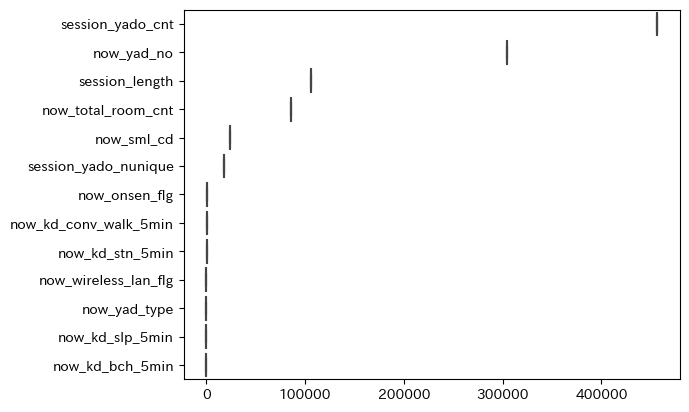

In [36]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.feature_importance(importance_type="gain") for model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=use_col)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(data=feature_importances_df, orient="h", order=order)

# Testに対する推論

In [37]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test[use_col]) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

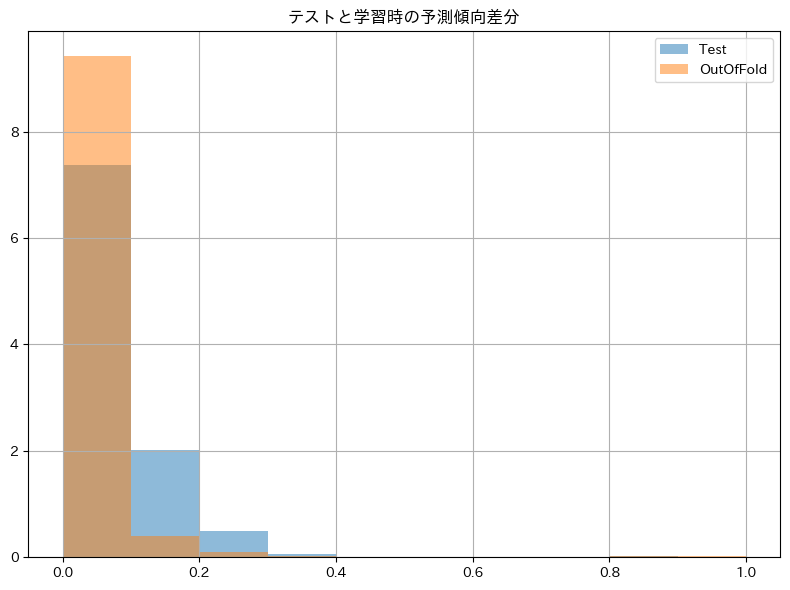

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [41]:
test["pred"] = pred

In [42]:
# TOP10に並び替え
# session_idごとにpredが高いyadoのlistを取得
pred_yad = (
    test.sort_values(["session_id", "pred"], ascending=False)
    .groupby("session_id")["yad_no"]
    .apply(list)
).to_dict()

test_session["pred_yad_no_list"] = test_session["session_id"].map(pred_yad)

# 上位10件に限定
test_session["pred_yad_no_list_top10"] = test_session["pred_yad_no_list"].apply(
    lambda x: x[:10]
)

# listをpd.Seriesに変換
pred_yad_df = test_session["pred_yad_no_list_top10"].apply(pd.Series)
pred_yad_df = pred_yad_df.rename(columns=lambda x: "predict_" + str(x))

# Nullの箇所はyad_no=0で保管し、全ての値をintに変換する
pred_yad_df = pred_yad_df.fillna(0).astype(int)

In [43]:
pred_yad_df.isnull().sum()

predict_0    0
predict_1    0
predict_2    0
predict_3    0
predict_4    0
predict_5    0
predict_6    0
predict_7    0
predict_8    0
predict_9    0
dtype: int64

In [44]:
pred_yad_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,9830,6766,1286,4422,2986,4128,9955,2680,6397
1,12862,6555,4066,5267,6129,10023,8821,7014,11237,7913
2,757,1774,4999,9910,9190,2142,410,6730,2267,11139
3,12341,277,5657,7049,7413,10527,2795,2047,6991,10535
4,5713,6576,12524,5106,13590,7246,3187,9020,11494,13436
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,831,7062,5744,10042,1885,2278,8771
174696,4541,1227,6874,2232,3802,4014,5331,9723,12432,13611
174697,7379,12425,12132,10155,12986,12089,8468,6199,8143,12240
174698,6378,2305,3100,10287,2692,2373,12688,1530,2614,5513


In [45]:
assert pred_yad_df.shape[0] == sample_submission.shape[0]
assert list(pred_yad_df.columns) == list(sample_submission.columns)

In [46]:
pred_yad_df.to_csv(
    f"../sub/{NOTEBOOK_NAME}_auc{oof_score:.4f}_mapk{oof_mapk_score:.4f}.csv",
    index=False,
)